In [1]:
# Import all the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
import nltk
import os
import re
import string
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer
from get_tweets import get_tweets_by_search_term
%matplotlib inline
pd.set_option('display.max_colwidth', 100)
pd.set_option("display.max_columns", None)

In [2]:
# Import NLTK lexicon
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('twitter_samples')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/brightkoech/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/brightkoech/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/brightkoech/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/brightkoech/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package twitter_samples to
[nltk_data]     /home/brightkoech/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!


True

In [8]:
# Fetch the Tweets
keywords = input("Enter keywords, hashtags separated by commas: ")
keywords = list(set(keywords.split(",")))
data = get_tweets_by_search_term(keywords)

Rate limit reached. Sleeping for: 100


In [10]:
# Save tweets to pickle file and reload to DF - Avoid API calls
this_file_path = os.path.abspath("__file__")
BASE_DIR = os.path.dirname(this_file_path)
tweet_pickle_file = os.path.join(BASE_DIR, "tweets", "tweet_list.pkl")
data.to_pickle(tweet_pickle_file)


In [11]:
# Read pickle file
tweets_df = pd.read_pickle(tweet_pickle_file)
tweets_df.head()

,UserId,TweetId,tweet,location,created
0,Ohta Ryota,1536610902950219776,Why do UDA minions think linking RAO to the 1982 coup is a bad thing? Kibaki's campaigners did i...,Nairobi,14-Jun-2022
1,WARE GONSO,1536610886605017088,most of those who are in azimio are just after their selfish interest and not fr kenyans.They do...,"Malindi, Kenya",14-Jun-2022
2,maraHABA,1536610596552065024,Some people fake it till they make it while some just document their experience till that level ...,,14-Jun-2022
3,Husaliq,1536610395422597120,These UDA conmen think kenyans are this ignorant.\nanother fake list from the overated economist...,omnipresent,14-Jun-2022
4,BIG MAVERICK🍀🇮🇪🍀,1536610180946968577,@gorbals1967 @mikehoops67 @ggbhoy @Pmacgiollabhain @TamsellicsonIII @CelticBlog2018 @RangersFC T...,"LURGAN,CO ARMAGH, IRELAND",14-Jun-2022


In [12]:
# Primary exploratory analysis
print('Dataset shape:', tweets_df.shape)
print('Dataset columns:', tweets_df.columns)
tweets_df.info()

Dataset shape: (5000, 5)
Dataset columns: Index(['UserId', 'TweetId', 'tweet', 'location', 'created'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   UserId    5000 non-null   object
 1   TweetId   5000 non-null   int64 
 2   tweet     5000 non-null   object
 3   location  5000 non-null   object
 4   created   5000 non-null   object
dtypes: int64(1), object(4)
memory usage: 195.4+ KB


In [13]:
# Drop all columns except for Tweet and create a list of all words
tweets_only_df = tweets_df.drop(['UserId', 'TweetId', 'location', 'created'], axis=1)
tweets_only_df.head()

,tweet
0,Why do UDA minions think linking RAO to the 1982 coup is a bad thing? Kibaki's campaigners did i...
1,most of those who are in azimio are just after their selfish interest and not fr kenyans.They do...
2,Some people fake it till they make it while some just document their experience till that level ...
3,These UDA conmen think kenyans are this ignorant.\nanother fake list from the overated economist...
4,@gorbals1967 @mikehoops67 @ggbhoy @Pmacgiollabhain @TamsellicsonIII @CelticBlog2018 @RangersFC T...


In [14]:
# Remove http links from tweets
def remove_http_https(text):
    return re.sub(r'http\S+', '', text)

tweets_only_df['link_removed'] = tweets_only_df['tweet'].apply(lambda x: remove_http_https(x))
tweets_only_df.head()

,tweet,link_removed
0,Why do UDA minions think linking RAO to the 1982 coup is a bad thing? Kibaki's campaigners did i...,Why do UDA minions think linking RAO to the 1982 coup is a bad thing? Kibaki's campaigners did i...
1,most of those who are in azimio are just after their selfish interest and not fr kenyans.They do...,most of those who are in azimio are just after their selfish interest and not fr kenyans.They do...
2,Some people fake it till they make it while some just document their experience till that level ...,Some people fake it till they make it while some just document their experience till that level ...
3,These UDA conmen think kenyans are this ignorant.\nanother fake list from the overated economist...,These UDA conmen think kenyans are this ignorant.\nanother fake list from the overated economist.
4,@gorbals1967 @mikehoops67 @ggbhoy @Pmacgiollabhain @TamsellicsonIII @CelticBlog2018 @RangersFC T...,@gorbals1967 @mikehoops67 @ggbhoy @Pmacgiollabhain @TamsellicsonIII @CelticBlog2018 @RangersFC T...


In [15]:
# Remove punctuations
#string.punctuation
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

tweets_only_df['tweet_punct'] = tweets_only_df['tweet'].apply(lambda x: remove_punct(x))
tweets_only_df.head()

,tweet,link_removed,tweet_punct
0,Why do UDA minions think linking RAO to the 1982 coup is a bad thing? Kibaki's campaigners did i...,Why do UDA minions think linking RAO to the 1982 coup is a bad thing? Kibaki's campaigners did i...,Why do UDA minions think linking RAO to the coup is a bad thing Kibakis campaigners did it in ...
1,most of those who are in azimio are just after their selfish interest and not fr kenyans.They do...,most of those who are in azimio are just after their selfish interest and not fr kenyans.They do...,most of those who are in azimio are just after their selfish interest and not fr kenyansThey don...
2,Some people fake it till they make it while some just document their experience till that level ...,Some people fake it till they make it while some just document their experience till that level ...,Some people fake it till they make it while some just document their experience till that level ...
3,These UDA conmen think kenyans are this ignorant.\nanother fake list from the overated economist...,These UDA conmen think kenyans are this ignorant.\nanother fake list from the overated economist.,These UDA conmen think kenyans are this ignorant\nanother fake list from the overated economist ...
4,@gorbals1967 @mikehoops67 @ggbhoy @Pmacgiollabhain @TamsellicsonIII @CelticBlog2018 @RangersFC T...,@gorbals1967 @mikehoops67 @ggbhoy @Pmacgiollabhain @TamsellicsonIII @CelticBlog2018 @RangersFC T...,gorbals mikehoops ggbhoy Pmacgiollabhain TamsellicsonIII CelticBlog RangersFC They definitely ar...


In [16]:
# Tokenize the tweets
def tokenize(text):
    text = re.split('\W+', text)
    return text

tweets_only_df['tweet_tokenized'] = tweets_only_df['tweet_punct'].apply(lambda x: tokenize(x))
tweets_only_df.head()

,tweet,link_removed,tweet_punct,tweet_tokenized
0,Why do UDA minions think linking RAO to the 1982 coup is a bad thing? Kibaki's campaigners did i...,Why do UDA minions think linking RAO to the 1982 coup is a bad thing? Kibaki's campaigners did i...,Why do UDA minions think linking RAO to the coup is a bad thing Kibakis campaigners did it in ...,"[Why, do, UDA, minions, think, linking, RAO, to, the, coup, is, a, bad, thing, Kibakis, campaign..."
1,most of those who are in azimio are just after their selfish interest and not fr kenyans.They do...,most of those who are in azimio are just after their selfish interest and not fr kenyans.They do...,most of those who are in azimio are just after their selfish interest and not fr kenyansThey don...,"[most, of, those, who, are, in, azimio, are, just, after, their, selfish, interest, and, not, fr..."
2,Some people fake it till they make it while some just document their experience till that level ...,Some people fake it till they make it while some just document their experience till that level ...,Some people fake it till they make it while some just document their experience till that level ...,"[Some, people, fake, it, till, they, make, it, while, some, just, document, their, experience, t..."
3,These UDA conmen think kenyans are this ignorant.\nanother fake list from the overated economist...,These UDA conmen think kenyans are this ignorant.\nanother fake list from the overated economist.,These UDA conmen think kenyans are this ignorant\nanother fake list from the overated economist ...,"[These, UDA, conmen, think, kenyans, are, this, ignorant, another, fake, list, from, the, overat..."
4,@gorbals1967 @mikehoops67 @ggbhoy @Pmacgiollabhain @TamsellicsonIII @CelticBlog2018 @RangersFC T...,@gorbals1967 @mikehoops67 @ggbhoy @Pmacgiollabhain @TamsellicsonIII @CelticBlog2018 @RangersFC T...,gorbals mikehoops ggbhoy Pmacgiollabhain TamsellicsonIII CelticBlog RangersFC They definitely ar...,"[gorbals, mikehoops, ggbhoy, Pmacgiollabhain, TamsellicsonIII, CelticBlog, RangersFC, They, defi..."


In [17]:
# Remove stopwords
stopwords = nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    text = [word for word in text if word not in stopwords]
    return text

tweets_only_df['tweet_nonstop'] = tweets_only_df['tweet_tokenized'].apply(lambda x: remove_stopwords(x))
tweets_only_df.head()

,tweet,link_removed,tweet_punct,tweet_tokenized,tweet_nonstop
0,Why do UDA minions think linking RAO to the 1982 coup is a bad thing? Kibaki's campaigners did i...,Why do UDA minions think linking RAO to the 1982 coup is a bad thing? Kibaki's campaigners did i...,Why do UDA minions think linking RAO to the coup is a bad thing Kibakis campaigners did it in ...,"[Why, do, UDA, minions, think, linking, RAO, to, the, coup, is, a, bad, thing, Kibakis, campaign...","[Why, UDA, minions, think, linking, RAO, coup, bad, thing, Kibakis, campaigners, still, failed, ..."
1,most of those who are in azimio are just after their selfish interest and not fr kenyans.They do...,most of those who are in azimio are just after their selfish interest and not fr kenyans.They do...,most of those who are in azimio are just after their selfish interest and not fr kenyansThey don...,"[most, of, those, who, are, in, azimio, are, just, after, their, selfish, interest, and, not, fr...","[azimio, selfish, interest, fr, kenyansThey, dont, respect, railaThey, fight, fr, positions, htt..."
2,Some people fake it till they make it while some just document their experience till that level ...,Some people fake it till they make it while some just document their experience till that level ...,Some people fake it till they make it while some just document their experience till that level ...,"[Some, people, fake, it, till, they, make, it, while, some, just, document, their, experience, t...","[Some, people, fake, till, make, document, experience, till, level, point, There, differenceBaba..."
3,These UDA conmen think kenyans are this ignorant.\nanother fake list from the overated economist...,These UDA conmen think kenyans are this ignorant.\nanother fake list from the overated economist.,These UDA conmen think kenyans are this ignorant\nanother fake list from the overated economist ...,"[These, UDA, conmen, think, kenyans, are, this, ignorant, another, fake, list, from, the, overat...","[These, UDA, conmen, think, kenyans, ignorant, another, fake, list, overated, economist, httpstc..."
4,@gorbals1967 @mikehoops67 @ggbhoy @Pmacgiollabhain @TamsellicsonIII @CelticBlog2018 @RangersFC T...,@gorbals1967 @mikehoops67 @ggbhoy @Pmacgiollabhain @TamsellicsonIII @CelticBlog2018 @RangersFC T...,gorbals mikehoops ggbhoy Pmacgiollabhain TamsellicsonIII CelticBlog RangersFC They definitely ar...,"[gorbals, mikehoops, ggbhoy, Pmacgiollabhain, TamsellicsonIII, CelticBlog, RangersFC, They, defi...","[gorbals, mikehoops, ggbhoy, Pmacgiollabhain, TamsellicsonIII, CelticBlog, RangersFC, They, defi..."


In [18]:
# Stemming and lemmatization
ps = nltk.PorterStemmer()
def stemming(text):
    text = [ps.stem(word) for word in text]
    return text

tweets_only_df['tweet_stemmed'] = tweets_only_df['tweet_nonstop'].apply(lambda x: stemming(x))

wn = nltk.WordNetLemmatizer()
def lemmatizer(text):
    text = [wn.lemmatize(word) for word in text]
    return text
tweets_only_df['tweet_lemmatized'] = tweets_only_df['tweet_stemmed'].apply(lambda x: lemmatizer(x))
tweets_only_df.head()

,tweet,link_removed,tweet_punct,tweet_tokenized,tweet_nonstop,tweet_stemmed,tweet_lemmatized
0,Why do UDA minions think linking RAO to the 1982 coup is a bad thing? Kibaki's campaigners did i...,Why do UDA minions think linking RAO to the 1982 coup is a bad thing? Kibaki's campaigners did i...,Why do UDA minions think linking RAO to the coup is a bad thing Kibakis campaigners did it in ...,"[Why, do, UDA, minions, think, linking, RAO, to, the, coup, is, a, bad, thing, Kibakis, campaign...","[Why, UDA, minions, think, linking, RAO, coup, bad, thing, Kibakis, campaigners, still, failed, ...","[whi, uda, minion, think, link, rao, coup, bad, thing, kibaki, campaign, still, fail, kibaki, be...","[whi, uda, minion, think, link, rao, coup, bad, thing, kibaki, campaign, still, fail, kibaki, be..."
1,most of those who are in azimio are just after their selfish interest and not fr kenyans.They do...,most of those who are in azimio are just after their selfish interest and not fr kenyans.They do...,most of those who are in azimio are just after their selfish interest and not fr kenyansThey don...,"[most, of, those, who, are, in, azimio, are, just, after, their, selfish, interest, and, not, fr...","[azimio, selfish, interest, fr, kenyansThey, dont, respect, railaThey, fight, fr, positions, htt...","[azimio, selfish, interest, fr, kenyansthey, dont, respect, railathey, fight, fr, posit, httpstc...","[azimio, selfish, interest, fr, kenyansthey, dont, respect, railathey, fight, fr, posit, httpstc..."
2,Some people fake it till they make it while some just document their experience till that level ...,Some people fake it till they make it while some just document their experience till that level ...,Some people fake it till they make it while some just document their experience till that level ...,"[Some, people, fake, it, till, they, make, it, while, some, just, document, their, experience, t...","[Some, people, fake, till, make, document, experience, till, level, point, There, differenceBaba...","[some, peopl, fake, till, make, document, experi, till, level, point, there, differencebaba, alr...","[some, peopl, fake, till, make, document, experi, till, level, point, there, differencebaba, alr..."
3,These UDA conmen think kenyans are this ignorant.\nanother fake list from the overated economist...,These UDA conmen think kenyans are this ignorant.\nanother fake list from the overated economist.,These UDA conmen think kenyans are this ignorant\nanother fake list from the overated economist ...,"[These, UDA, conmen, think, kenyans, are, this, ignorant, another, fake, list, from, the, overat...","[These, UDA, conmen, think, kenyans, ignorant, another, fake, list, overated, economist, httpstc...","[these, uda, conmen, think, kenyan, ignor, anoth, fake, list, over, economist, httpstcoqxumpkj, ...","[these, uda, conmen, think, kenyan, ignor, anoth, fake, list, over, economist, httpstcoqxumpkj, ..."
4,@gorbals1967 @mikehoops67 @ggbhoy @Pmacgiollabhain @TamsellicsonIII @CelticBlog2018 @RangersFC T...,@gorbals1967 @mikehoops67 @ggbhoy @Pmacgiollabhain @TamsellicsonIII @CelticBlog2018 @RangersFC T...,gorbals mikehoops ggbhoy Pmacgiollabhain TamsellicsonIII CelticBlog RangersFC They definitely ar...,"[gorbals, mikehoops, ggbhoy, Pmacgiollabhain, TamsellicsonIII, CelticBlog, RangersFC, They, defi...","[gorbals, mikehoops, ggbhoy, Pmacgiollabhain, TamsellicsonIII, CelticBlog, RangersFC, They, defi...","[gorbal, mikehoop, ggbhoy, pmacgiollabhain, tamsellicsoniii, celticblog, rangersfc, they, defini...","[gorbal, mikehoop, ggbhoy, pmacgiollabhain, tamsellicsoniii, celticblog, rangersfc, they, defini..."


(-0.5, 399.5, 199.5, -0.5)

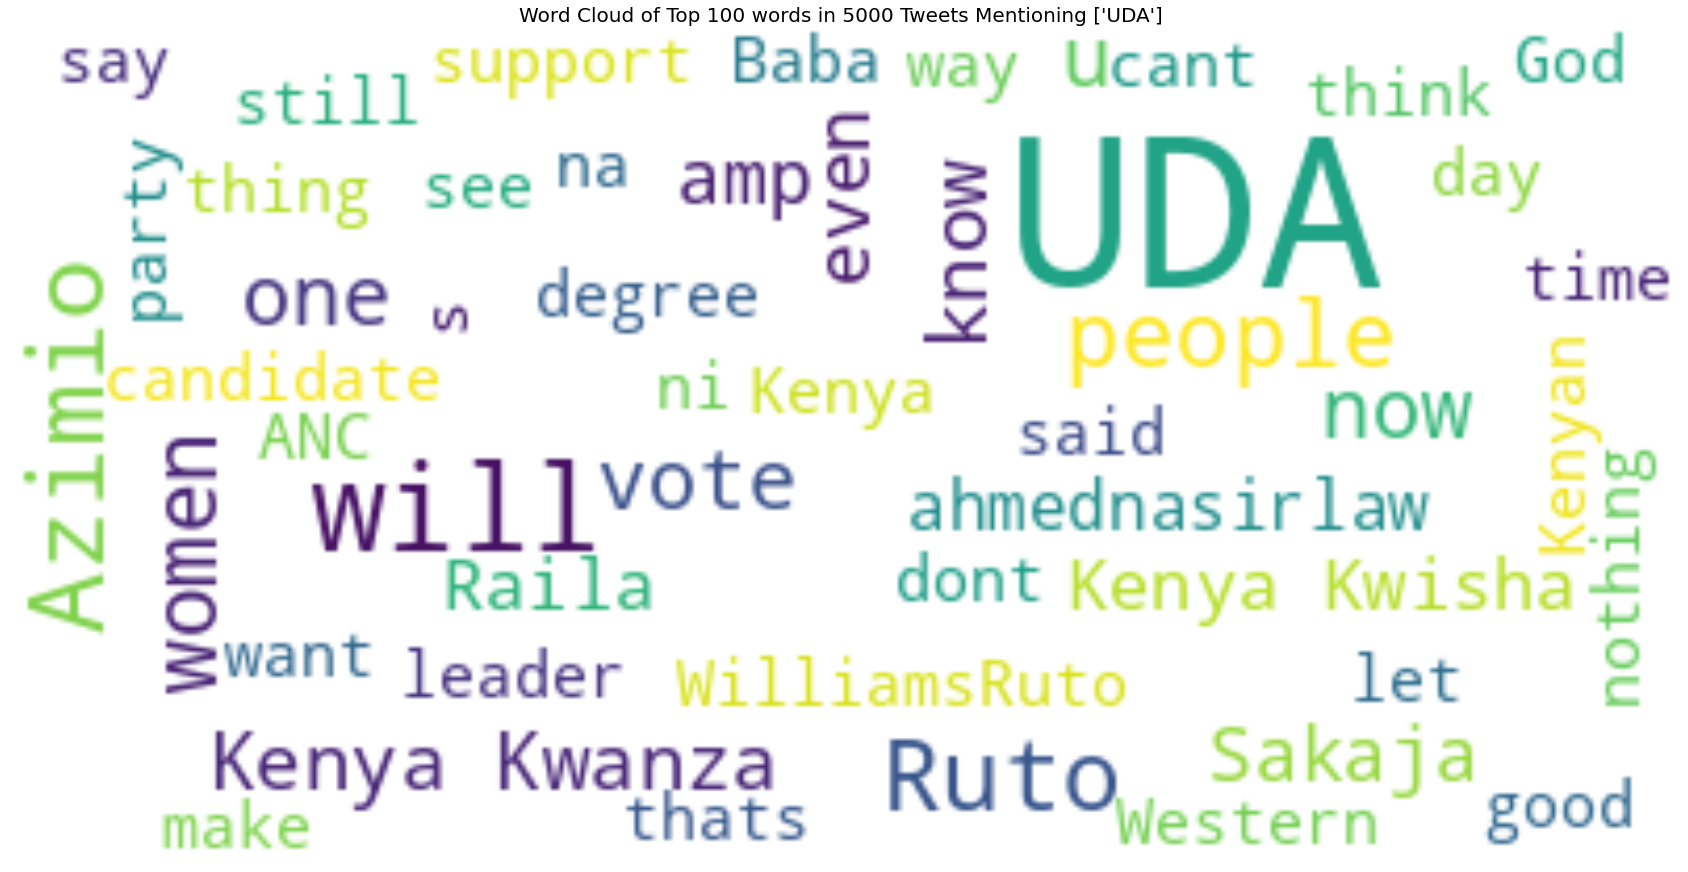

In [19]:
all_final_tweets = ' '.join(word for word in tweets_only_df['tweet_punct'])
fig, ax = plt.subplots(figsize=(30,30))
wordcloud_all_tweets = WordCloud(max_font_size=50, max_words=50, background_color="white").generate(all_final_tweets)
ax.imshow(wordcloud_all_tweets, interpolation='bilinear')
ax.set_title(f'Word Cloud of Top 100 words in 5000 Tweets Mentioning {keywords} ', fontsize=20)
ax.axis("off")

In [20]:
# Subjectivity of the tweets using TextBlob
def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def get_polarity(text):
    return TextBlob(text).sentiment.polarity

tweets_df['subjectivity'] = tweets_df['tweet'].apply(get_subjectivity)
tweets_df['polarity'] = tweets_df['tweet'].apply(get_polarity)
tweets_df.head(10)

,UserId,TweetId,tweet,location,created,subjectivity,polarity
0,Ohta Ryota,1536610902950219776,Why do UDA minions think linking RAO to the 1982 coup is a bad thing? Kibaki's campaigners did i...,Nairobi,14-Jun-2022,0.483333,-0.600000
1,WARE GONSO,1536610886605017088,most of those who are in azimio are just after their selfish interest and not fr kenyans.They do...,"Malindi, Kenya",14-Jun-2022,0.750000,0.000000
2,maraHABA,1536610596552065024,Some people fake it till they make it while some just document their experience till that level ...,,14-Jun-2022,0.587500,-0.312500
3,Husaliq,1536610395422597120,These UDA conmen think kenyans are this ignorant.\nanother fake list from the overated economist...,omnipresent,14-Jun-2022,1.000000,-0.500000
4,BIG MAVERICK🍀🇮🇪🍀,1536610180946968577,@gorbals1967 @mikehoops67 @ggbhoy @Pmacgiollabhain @TamsellicsonIII @CelticBlog2018 @RangersFC T...,"LURGAN,CO ARMAGH, IRELAND",14-Jun-2022,0.633333,0.316667
5,Reagan Moseti,1536609209151782912,@maktejah_ Uda will be told to front another candidate,"Nairobi, Kenya",14-Jun-2022,0.000000,0.000000
6,Rodgers Oduor,1536609029874667521,"@UDAKenya does NOT have an agenda for the country. ""Bottom up"" is just a SLOGAN.\nBoth AZIMIO an...","Nairobi, Kenya",14-Jun-2022,0.000000,0.000000
7,AR 14,1536608831366500352,@BiamKynsai @rahulbhat282 @yuvi_010 @IndianFootball @IHateElonMuskk @afcasiancup @theafcdotcom @...,,14-Jun-2022,0.750000,-0.275000
8,Paul Oliver,1536608711350837248,"Remember that the DUP are in a public pact with the UVF and UDA, both drug dealing terrorists, w...",,14-Jun-2022,0.283333,-0.100000
9,Opus Dei,1536608455175426048,"@YussufMwinyi @NaitwaJeff They should ALL go home, Senior. The law must be a double edged sword....",,14-Jun-2022,0.345238,0.261905


In [21]:
# Compute negative, neutral, positive analysis of the tweets
def get_analysis(score):
    if score < 0:
        return 'Negative'
    elif score== 0:
        return 'Neutral'
    else:
        return 'Positive'

tweets_df['analysis'] = tweets_df['polarity'].apply(get_analysis)
tweets_df.head(10)

,UserId,TweetId,tweet,location,created,subjectivity,polarity,analysis
0,Ohta Ryota,1536610902950219776,Why do UDA minions think linking RAO to the 1982 coup is a bad thing? Kibaki's campaigners did i...,Nairobi,14-Jun-2022,0.483333,-0.600000,Negative
1,WARE GONSO,1536610886605017088,most of those who are in azimio are just after their selfish interest and not fr kenyans.They do...,"Malindi, Kenya",14-Jun-2022,0.750000,0.000000,Neutral
2,maraHABA,1536610596552065024,Some people fake it till they make it while some just document their experience till that level ...,,14-Jun-2022,0.587500,-0.312500,Negative
3,Husaliq,1536610395422597120,These UDA conmen think kenyans are this ignorant.\nanother fake list from the overated economist...,omnipresent,14-Jun-2022,1.000000,-0.500000,Negative
4,BIG MAVERICK🍀🇮🇪🍀,1536610180946968577,@gorbals1967 @mikehoops67 @ggbhoy @Pmacgiollabhain @TamsellicsonIII @CelticBlog2018 @RangersFC T...,"LURGAN,CO ARMAGH, IRELAND",14-Jun-2022,0.633333,0.316667,Positive
5,Reagan Moseti,1536609209151782912,@maktejah_ Uda will be told to front another candidate,"Nairobi, Kenya",14-Jun-2022,0.000000,0.000000,Neutral
6,Rodgers Oduor,1536609029874667521,"@UDAKenya does NOT have an agenda for the country. ""Bottom up"" is just a SLOGAN.\nBoth AZIMIO an...","Nairobi, Kenya",14-Jun-2022,0.000000,0.000000,Neutral
7,AR 14,1536608831366500352,@BiamKynsai @rahulbhat282 @yuvi_010 @IndianFootball @IHateElonMuskk @afcasiancup @theafcdotcom @...,,14-Jun-2022,0.750000,-0.275000,Negative
8,Paul Oliver,1536608711350837248,"Remember that the DUP are in a public pact with the UVF and UDA, both drug dealing terrorists, w...",,14-Jun-2022,0.283333,-0.100000,Negative
9,Opus Dei,1536608455175426048,"@YussufMwinyi @NaitwaJeff They should ALL go home, Senior. The law must be a double edged sword....",,14-Jun-2022,0.345238,0.261905,Positive


In [22]:
def analyse_subjectivity(score):
    if score < 0.5:
        return 'Objective'
    else:
        return 'Subjective'

tweets_df['subjectivity_analysis'] = tweets_df['subjectivity'].apply(analyse_subjectivity)
tweets_df.head(10)

,UserId,TweetId,tweet,location,created,subjectivity,polarity,analysis,subjectivity_analysis
0,Ohta Ryota,1536610902950219776,Why do UDA minions think linking RAO to the 1982 coup is a bad thing? Kibaki's campaigners did i...,Nairobi,14-Jun-2022,0.483333,-0.600000,Negative,Objective
1,WARE GONSO,1536610886605017088,most of those who are in azimio are just after their selfish interest and not fr kenyans.They do...,"Malindi, Kenya",14-Jun-2022,0.750000,0.000000,Neutral,Subjective
2,maraHABA,1536610596552065024,Some people fake it till they make it while some just document their experience till that level ...,,14-Jun-2022,0.587500,-0.312500,Negative,Subjective
3,Husaliq,1536610395422597120,These UDA conmen think kenyans are this ignorant.\nanother fake list from the overated economist...,omnipresent,14-Jun-2022,1.000000,-0.500000,Negative,Subjective
4,BIG MAVERICK🍀🇮🇪🍀,1536610180946968577,@gorbals1967 @mikehoops67 @ggbhoy @Pmacgiollabhain @TamsellicsonIII @CelticBlog2018 @RangersFC T...,"LURGAN,CO ARMAGH, IRELAND",14-Jun-2022,0.633333,0.316667,Positive,Subjective
5,Reagan Moseti,1536609209151782912,@maktejah_ Uda will be told to front another candidate,"Nairobi, Kenya",14-Jun-2022,0.000000,0.000000,Neutral,Objective
6,Rodgers Oduor,1536609029874667521,"@UDAKenya does NOT have an agenda for the country. ""Bottom up"" is just a SLOGAN.\nBoth AZIMIO an...","Nairobi, Kenya",14-Jun-2022,0.000000,0.000000,Neutral,Objective
7,AR 14,1536608831366500352,@BiamKynsai @rahulbhat282 @yuvi_010 @IndianFootball @IHateElonMuskk @afcasiancup @theafcdotcom @...,,14-Jun-2022,0.750000,-0.275000,Negative,Subjective
8,Paul Oliver,1536608711350837248,"Remember that the DUP are in a public pact with the UVF and UDA, both drug dealing terrorists, w...",,14-Jun-2022,0.283333,-0.100000,Negative,Objective
9,Opus Dei,1536608455175426048,"@YussufMwinyi @NaitwaJeff They should ALL go home, Senior. The law must be a double edged sword....",,14-Jun-2022,0.345238,0.261905,Positive,Objective


In [23]:
# Compute the number of positive, negative and neutral tweets
tweets_df['analysis'].value_counts()

Neutral     2005
Positive    1881
Negative    1114
Name: analysis, dtype: int64

Text(0.5, 1.0, "Histogram of the Polarity of the Tweets - ['UDA']")

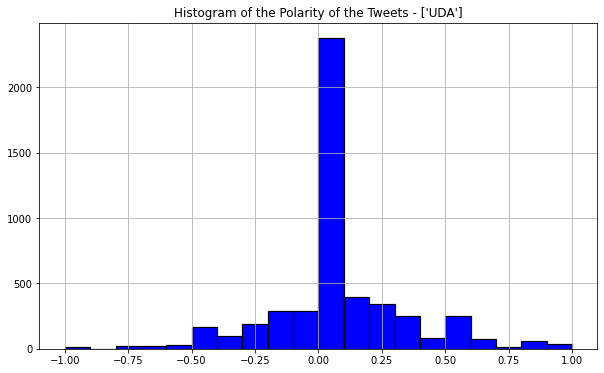

In [24]:
# Plot histogram of the polarity of the tweets
ax0 = tweets_df['polarity'].hist(bins=20, color='blue', edgecolor='black', linewidth=1.2, figsize=(10, 6))
ax0.set_title(f'Histogram of the Polarity of the Tweets - {keywords}', fontsize=12)

Text(0.5, 1.0, "Analysis of Tweets by Search Term: ['UDA']")

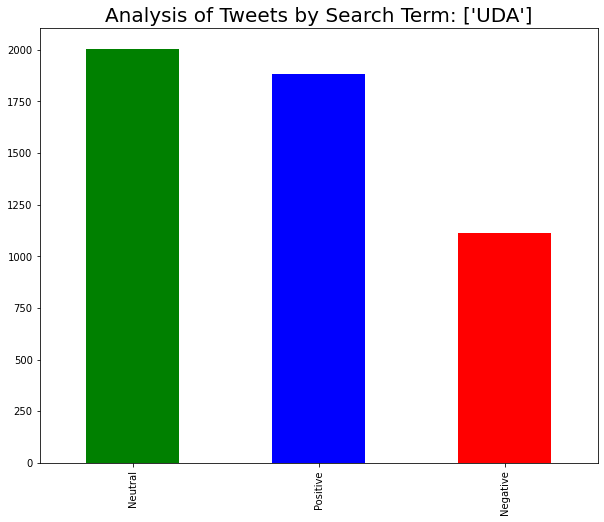

In [25]:
# Plotting the polarity of the tweets
ax1 = tweets_df['analysis'].value_counts().plot(kind='bar', color=['green', 'blue', 'red'], figsize=(10, 8))
ax1.set_title(f'Analysis of Tweets by Search Term: {keywords}', fontsize=20)

Text(0.5, 1.0, "% of Positive, Negative and Neutral Tweets - ['UDA']")

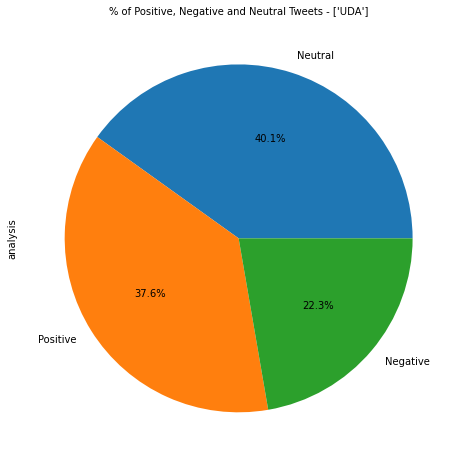

In [26]:
# Pie chart of the polarity of the tweets
ax3 = tweets_df['analysis'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(10, 8))
ax3.set_title(f'% of Positive, Negative and Neutral Tweets - {keywords}', fontsize=10)

Text(0.5, 1.0, "% of Subjective Tweets - ['UDA']")

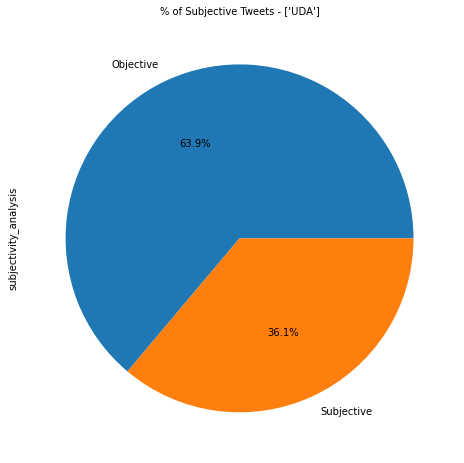

In [27]:
# Pie chart of the subjectivity of the tweets
ax3 = tweets_df['subjectivity_analysis'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(10, 8))
ax3.set_title(f'% of Subjective Tweets - {keywords}', fontsize=10)

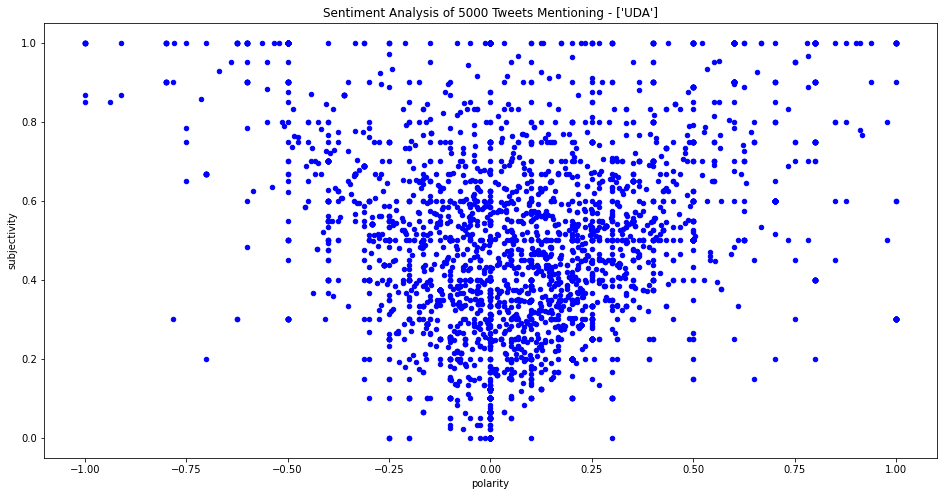

In [28]:
# Plot polarity and subjectivity of the tweets
ax4 = tweets_df.plot(kind='scatter', x='polarity', y='subjectivity', color='blue', figsize=(16,8))
ax4.title.set_text(f'Sentiment Analysis of 5000 Tweets Mentioning - {keywords}')